In [139]:
import pandas as pd
import numpy as np
import xgboost as xgb

import sklearn.preprocessing as skpp
from sklearn.grid_search import RandomizedSearchCV
from sklearn.grid_search import GridSearchCV

import datetime

import matplotlib.pyplot as plt

from mimicpreprocess import DataHandler

In [2]:
dh = DataHandler()
dh.connect()

In [3]:
admissions = dh.admissions_query()
patients = dh.patient_query()
dh.prior_hospital_stays(admissions)

In [4]:
# patient_ids = patient_info.subject_id.tolist()
# patient_hadm_ids = patient_info.hadm_id.tolist()

# hadm_id_tuple_list = zip(patient_ids, patient_hadm_ids)

# prior_visits_query = dh.session.query(dh.Admission).filter(dh.Admission.subject_id.in_(patient_ids))
# prior_visits = pd.read_sql(prior_visits_query.statement, prior_visits_query.session.bind).groupby('subject_id')

# admissions['prior'] = np.nan

# for patient_id, group in prior_visits:
#     patient_admissions = [item for item in hadm_id_tuple_list if item[0] == patient_id]

#     for item in patient_admissions:
#         admit_time = group.loc[group['hadm_id'] == item[1]].iloc[0]['admittime']
#         priors = len(group[(group['admittime'] < admit_time)])
#         admissions.loc[admissions.hadm_id == item[1], 'prior'] = priors

In [5]:
# Join patients and admission dataframes to obtain gender and age of patient
patient_info = admissions.join(patients.set_index('subject_id'), on='subject_id')

In [6]:
patient_info['age'] = patient_info.apply (lambda row: dh.age (row),axis=1)

In [7]:
patient_vitals = dh.lab_event_query(patient_info)

In [8]:
patient_vitals.isnull().sum()

oxygen                   836
pco2                     412
PH                       355
po2                      412
tempurature              634
lipase                   436
hematocrit                 9
hemoglobin                10
INR                       68
lymphocytes               58
alkaline phosphatase     198
MCH                       11
amylase                  627
neutrophils               58
BUN                        8
platelet                   8
bicarbonate               14
CRP                      993
PTT                       68
PT                        72
RBCDW                     10
calcium                   23
ESR                     1120
creatinine                 8
WBC                     1172
glucose                    9
AST                      183
lactate                   86
dtype: int64

In [9]:
from itertools import chain
# Vitals that will be kept. The rest dropped due to lack of data
keep_vitals = ['bicarbonate' ,'INR' ,'MCH' ,'AST','alkaline phosphatase' , 'creatinine', 'platelet', 'PT', 'PTT', 'lymphocytes', 'RBCDW', 'calcium', 'neutrophils', 'glucose', 'hematocrit', 'hemoglobin', 'lactate', 'BUN']
# keep_vitals = keep_vitals + list(chain.from_iterable((x + '_max', x + '_min') for x in keep_vitals))
patient_vitals_fixed = patient_vitals[keep_vitals]

In [10]:
# Find all hadm_ids where there are 6 or greater missing values. 
drop_hadm_ids = patient_vitals_fixed[patient_vitals_fixed.isnull().sum(axis=1) >= 6].index

In [11]:
patient_vitals_final = patient_vitals_fixed[~patient_vitals_fixed.index.isin(drop_hadm_ids)]

In [12]:
# Replace NaN values with the mean of each column. In the actual ML phase it may be worth figuring out WHY
# Some values are missing. Here we will simply continue with mean.
patient_vitals_final = patient_vitals_final.fillna(patient_vitals.mean())

In [13]:
# Add age column prior to standardization
# keep_vitals.append(['age', 'prior'])
keep_vitals = keep_vitals + ['age', 'prior']

In [14]:
patient_info = patient_info[~patient_info.hadm_id.isin(drop_hadm_ids)]

In [145]:
# New patient info dataframe finally with vitals
vital_patient_info = patient_info.join(patient_vitals_final, on='hadm_id')
# vital_patient_info.isnull().sum()
# Standardize the data from vital columns
stdsc = skpp.StandardScaler()
vital_patient_info[keep_vitals] = stdsc.fit_transform(vital_patient_info[keep_vitals])

In [16]:
potential_outliers = []
from collections import Counter
from IPython.display import display

# For each feature find the data points with extreme high or low values
for feature in patient_vitals_final.keys():

    # Calculate Q1
    Q1 = np.percentile(patient_vitals_final[feature], 25)
    
    # Calculate Q3
    Q3 = np.percentile(patient_vitals_final[feature], 75)
    
    step = 1.5*(Q3-Q1)
    
    # Display the outliers
    outlier = patient_vitals_final[~((patient_vitals_final[feature] >= Q1 - step) & (patient_vitals_final[feature] <= Q3 + step))]
    potential_outliers += outlier.index.tolist()
    
# print Counter(potential_outliers)
# len({k:v for (k,v) in Counter(potential_outliers).items() if v > 4})
outliers = [k for (k,v) in Counter(potential_outliers).items() if v > 4]

In [149]:
vital_patient_info = vital_patient_info[~vital_patient_info.index.isin(outliers)]

In [110]:
y_vitals = vital_patient_info['death_period']
X_vitals = vital_patient_info.drop(['death_period', 'subject_id', 'hadm_id', 'admittime', 'admission_type', 'insurance', 'ethnicity', 'dob'], 1) # 'insurance', 'admission_type', 'gender',
X_vitals = pd.get_dummies(X_vitals)

In [19]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {
              "n_estimators": list(range(1,1000)),
             }

forest = RandomForestClassifier( random_state=42)

In [20]:
rand_for = RandomizedSearchCV(forest, param_grid, scoring = 'accuracy', n_iter=20, random_state=42)
_ = rand_for.fit(X_vitals,y_vitals)

In [21]:
print(rand_for.best_score_)
print(rand_for.best_params_)
print(rand_for.best_estimator_)

0.82448630137
{'n_estimators': 131}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=131, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)


In [22]:
importances = rand_for.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_vitals.shape[1]):
    print "{}) {} {}".format(f, X_vitals.columns[indices[f]], importances[indices[f]])

0) lactate 0.115434454591
1) bicarbonate 0.0671209293989
2) BUN 0.0650089043145
3) PT 0.0573642132081
4) RBCDW 0.0537664646406
5) calcium 0.0506562312684
6) AST 0.0503630033364
7) creatinine 0.0484696039888
8) platelet 0.0450930026933
9) MCH 0.0450482153684
10) hematocrit 0.0440781553888
11) age 0.0434707992538
12) neutrophils 0.0414743800425
13) PTT 0.0405690905634
14) glucose 0.0402378295885
15) lymphocytes 0.0394811695245
16) hemoglobin 0.0393673406357
17) alkaline phosphatase 0.0388349571895
18) INR 0.0384430052938
19) prior 0.0132265514185
20) gender_M 0.00528846799034
21) gender_F 0.00515472375546
22) insurance_Medicare 0.0040038224327
23) insurance_Private 0.00385707665873
24) insurance_Medicaid 0.00222104268767
25) insurance_Government 0.000757941182478
26) admission_type_URGENT 0.000671819172487
27) admission_type_EMERGENCY 0.000446841655848
28) insurance_Self Pay 8.99627565743e-05


## Support Vector Machine

In [135]:
from sklearn.svm import SVC

In [140]:
sv_clf = SVC(random_state=42)

param_grid = [
              {'C': [1, 10, 100, 1000], 
               'kernel': ['linear']
              },
              {'C': [1, 10, 100, 1000], 
               'gamma': [0.001, 0.0001], 
               'kernel': ['rbf']
              },
 ]

In [141]:
grid_sv = GridSearchCV(sv_clf, param_grid, cv=10, scoring="accuracy")
grid_sv.fit(X_vitals,y_vitals)

GridSearchCV(cv=10, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'kernel': ['linear'], 'C': [1, 10, 100, 1000]}, {'kernel': ['rbf'], 'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001]}],
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [142]:
print(grid_sv.best_score_)
print(grid_sv.best_params_)
print(grid_sv.best_estimator_)

0.818493150685
{'kernel': 'rbf', 'C': 1000, 'gamma': 0.001}
SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)


## Extreme Gradient Boosting

In [23]:
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import cross_val_score

In [24]:
model = xgb.XGBClassifier(objective='binary:logistic')
# kfold = KFold(n_folds=10, random_state=42)
kfold = StratifiedKFold(y_vitals, n_folds=10, random_state=42)
results = cross_val_score(model, X_vitals, y_vitals, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 82.28% (2.37%)


In [26]:
param_grid = {
                "max_depth": list(range(1,20)),
                "gamma": list(range(0, 20)) + [i/10.0 for i in range(0,10)],
                "min_child_weight":list(range(0,20))
                
             }

In [27]:
rand_XGB = RandomizedSearchCV(xgb.XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), param_grid, scoring = 'accuracy', n_iter=100, random_state=42)
_ = rand_XGB.fit(X_vitals,y_vitals)

In [28]:
print(rand_XGB.best_score_)
print(rand_XGB.best_params_)
print(rand_XGB.best_estimator_)

0.830479452055
{'gamma': 6, 'max_depth': 8, 'min_child_weight': 13}
XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=6, learning_rate=0.1, max_delta_step=0, max_depth=8,
       min_child_weight=13, missing=None, n_estimators=140, nthread=4,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8)


## Neural Network with Keras/TensorFlow

In [50]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.constraints import maxnorm

model = Sequential()

In [150]:
model = Sequential()

model.add(Dense(125, input_dim=len(X_vitals.columns), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.5))
model.add(Dense(20, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.5))
model.add(Dense(10, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [151]:
history = model.fit(X_vitals.as_matrix(), y_vitals.as_matrix(), validation_split=0.33, epochs=500, batch_size=128, verbose=0)

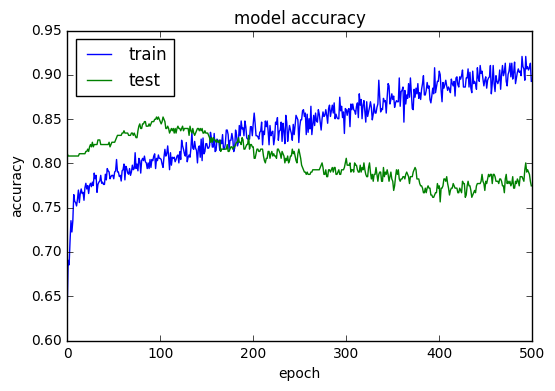

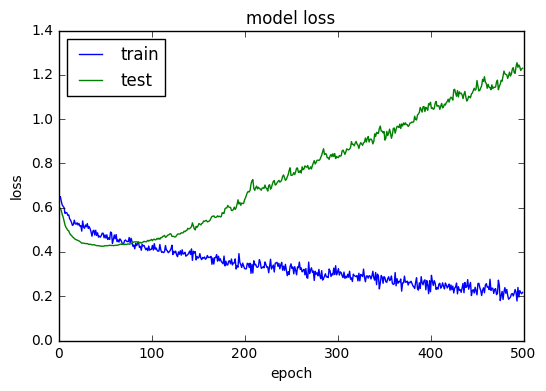

In [152]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [153]:
history.history['val_acc']

[0.81088082901554404,
 0.80829015544041449,
 0.80829015544041449,
 0.80829015544041449,
 0.80829015544041449,
 0.80829015544041449,
 0.80829015544041449,
 0.80829015544041449,
 0.80829015544041449,
 0.80829015544041449,
 0.80829015544041449,
 0.80829015544041449,
 0.80829015544041449,
 0.81088082901554404,
 0.81088082901554404,
 0.81088082901554404,
 0.81088082901554404,
 0.81088082901554404,
 0.81088082901554404,
 0.81088082901554404,
 0.81347150259067358,
 0.81347150259067358,
 0.81606217616580312,
 0.81347150259067358,
 0.81865284974093266,
 0.82124352331606221,
 0.81865284974093266,
 0.82383419689119175,
 0.81865284974093266,
 0.82124352331606221,
 0.82124352331606221,
 0.82124352331606221,
 0.82124352331606221,
 0.82642487046632129,
 0.82642487046632129,
 0.82642487046632129,
 0.82124352331606221,
 0.82124352331606221,
 0.82124352331606221,
 0.82124352331606221,
 0.82124352331606221,
 0.82124352331606221,
 0.82124352331606221,
 0.82124352331606221,
 0.82124352331606221,
 0.8238341